# A Quick Guide to LightKurve Ver. 1.0.1
   Derived from the Tutorials provided by LightKurve
   
   By Elizabeth Warrick

### Part I: How to download a TESS Data Set
There are two ways to download a TESS data set from a Target Pixel File or a Light Curve File. Start by creating a variable to attach the data to. The usual variable used is `tpf` for data from a target pixel file and `lcf` for data from a light curve file. 

For TPFs there are the following two ways to download data:

1. Using `TessTargetPixelFile('url')` with accompanying web address from the MAST archive *or*
2. Using `search_targetpixelfile(targetID, radius=float, cadence='long' or 'short', mission=['TESS'], sector=int, month=int, limit=int).download();`, where `limit` is the max number of products to return. To download a single, specific target you need to limit the search by using tow or more parameters. Usually those parameters are the TIC and the sector. 

Now, lets go through an example using a TPF of the first TESS Planet candidate. Please note this target was also used in examples found on Lightkurve's own tutorial page. This data set was chosen as it uses tools needed in both Parts I-III.

Let's start by downloading the TPF.

In [1]:
%matplotlib inline
from lightkurve import search_targetpixelfile
from lightkurve import periodogram

In [2]:
tpf = search_targetpixelfile(300808472, sector=1).download();

The target pixel file is now downloaded and you can access various information relavant to the target such as, but not limited to: mission, target ID, sector, and camera. The full list can be found in the [API Documentation](http://docs.lightkurve.org/api/index.html "API DOcumentation") on Lightkurve's website. The basic way is to use `tpf.info`, for example:

In [3]:
tpf.mission

'TESS'

In [4]:
tpf.targetid

300808472

Another useful thing to do once the TPF is downloaded is to plot the data of one cadence to get a better look at the target. Here is TIC 261136679 at frame = 0.

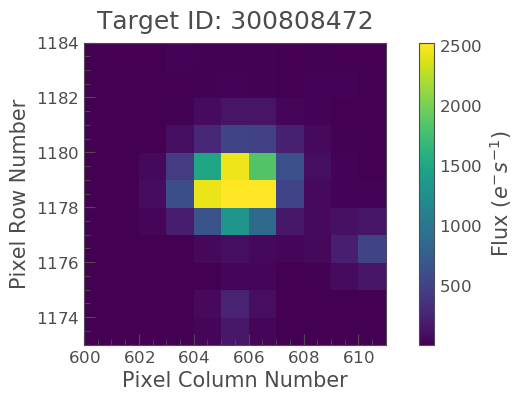

In [5]:
tpf.plot(frame=0);

If we had the local url, then we would apply the `TessTargetPixelFile` function.

For LCFs there are also two ways:

3. Using `TessLightCurveFile('url')` where the url is the specific url of the FITS file in lc format. 
4. Using `search_lightcurvefile(targetID, radius=float, cadence='long' or 'short', mission=['TESS'], sector=int, month=int, limit=int).download();`

This method will not be explained for the sake of keeping this guide somewhat concise but an explanation can be added if requested. 

### Part II: Plotting the Light Curve with No Operations
The method of plotting a light curve depends on whether you are working with a TPF or a LCF. 

The simplest method is by downloading your desired data as an LCF and then using the command `lcf.plot();`.

For TPFs, the process has a few more steps. Once the desired data is downloaded, you can turn the TPF into an LCF with the following command: `lc=tpf.to_lightcurve(aperture_mask= )` where the aperture mask can be the predetermined `tpf.pipeline_mask` (by substituting this at the equal sign or by leaving parenthesis empyt) or a custom aperture (see: "How to perform aperture photometry with custom apertures" on LightKurve's Tutorials page). From there, use the following lines of code: 

>`%matplotlib inline`

>`lc.plot();`

This produces the unmodified light curve from a TPF. 

Lets use the same TPF as before.

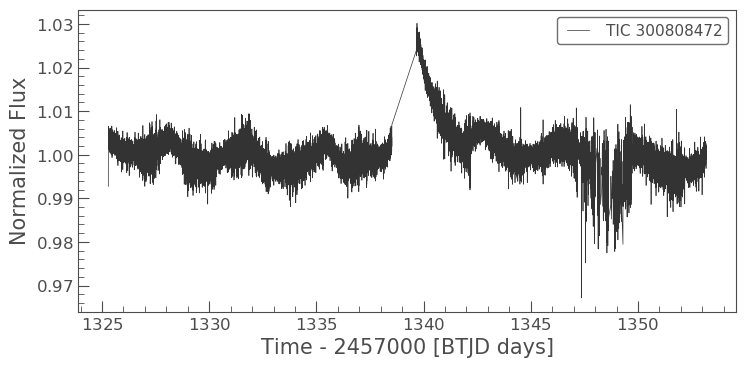

In [6]:
lc = tpf.to_lightcurve()
lc.plot();

Lets plot the lightcurve with error bars and then as a scatter plot to see the different plots.

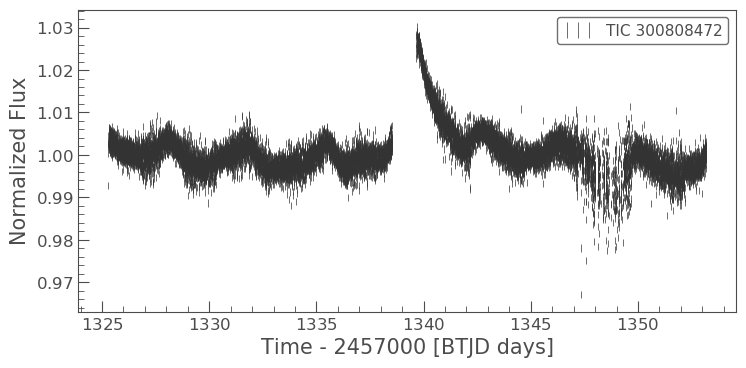

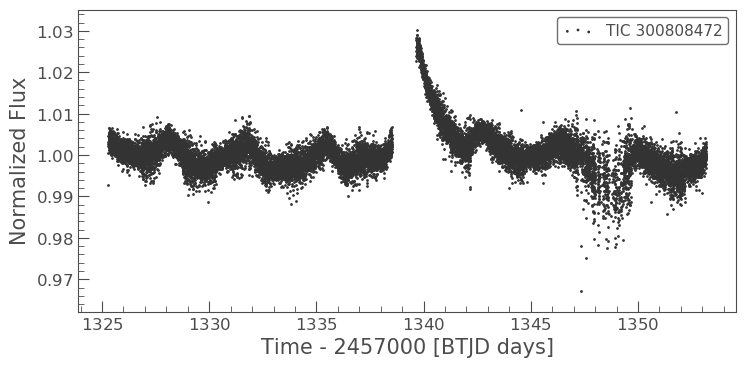

In [7]:
lc.errorbar();
lc.scatter();

In [8]:
# Number of cadences in the full light curve
print(lc.time.shape)

(18104,)


Decent light curve, lets see if it can be improved. This is where the operations comes in handy. 

### Part III: Useful Operations/Functions in Lightcurve Objects
The following is a list of possible operations:

* `flatten(window_length= )`: Removes longterm low frequency trends using a Savitzky-Golay filter where window length is the length of the filter window. 

* `remove_outliers(sigma= )`: Removes outliers using simple sigma clipping. 

* `remove_nans()`: Removes infinite or NaN values (preferred operation for removing). 

* `fold(period= )`: Folds the data at a particular period. The best period can be determined using additional code explained in the seciton on Periodograms. 

* `bin(binsize= )`: Reduces the time resolution of the array by taking the average value in each bin. 

These operations are key in adjusting the light curve to display accurate results. This can also be done in one line of code for example:
> `lc.remove_nans().flatten(window_length= ).fold(period= ).bin(binsize= ).plot();`

Using the same TPF as in previous examples, lets perform some of the operations to see how they effect the light curve of the TPF and if it is an improvment. 

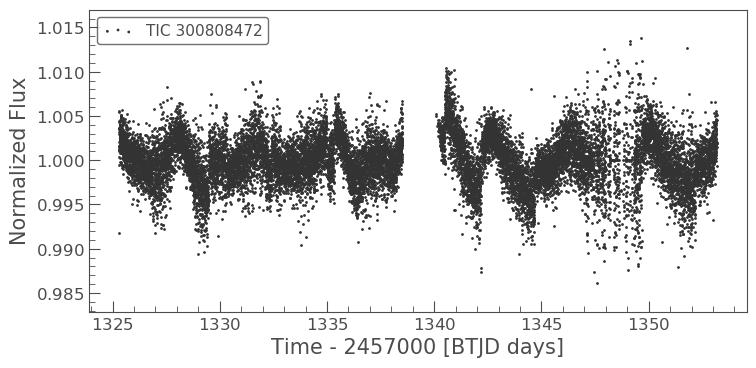

In [9]:
lc.remove_outliers(sigma=4).flatten(window_length=18101).scatter();

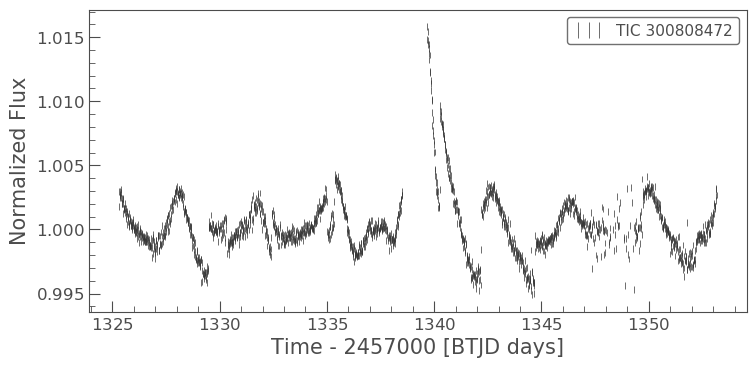

In [10]:
lc.remove_outliers(sigma=6).flatten(window_length= 18101).bin(binsize=10).errorbar();

This lightcurve does not look ideal. Lets see if the lightcurve will improve by changing the aperture. 

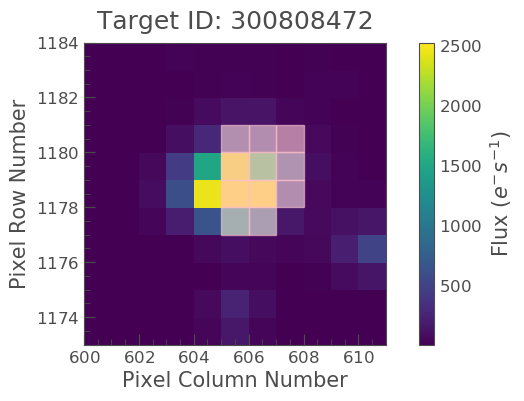

In [11]:
tpf.plot(aperture_mask=tpf.pipeline_mask);

Notice that it appears that part of the target might not be included. Perhaps if we change the aperture then we would see a better periodic light curve.  

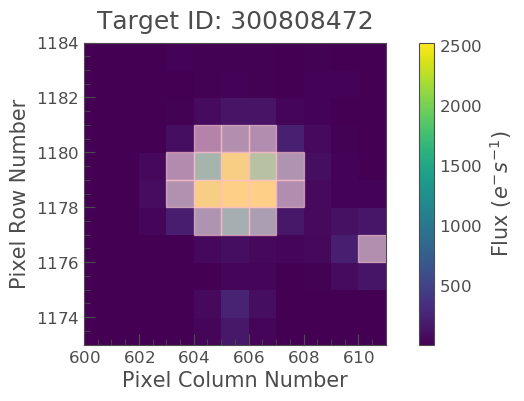

In [12]:
#This code is used to create a new aperture. Please note that this code is from Lightkurve Tutorials. 
import numpy as np
# Create a median image of the source over time
median_image = np.nanmedian(tpf.flux, axis=0)
# Select pixels which are brighter than the 86th percentile of the median image
aperture_mask = median_image > np.nanpercentile(median_image, 86)
# Plot that aperture
tpf.plot(aperture_mask=aperture_mask);

Much better! Now, lets apply this as the aperture mask to our light curve.

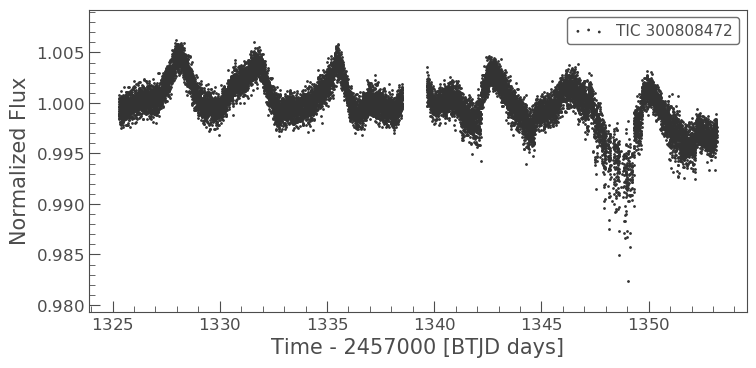

In [13]:
lc=tpf.to_lightcurve(aperture_mask=aperture_mask)
lc.scatter();

Lets compare the two apertures to see why the custom aperture produced a better light curve.

In [23]:
# Use the default
lcf = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask)
lcf = lcf.remove_outliers(sigma=6).bin(1)

# Use a custom aperture
custom_lc = tpf.to_lightcurve(aperture_mask=aperture_mask)
custom_lc = custom_lc.remove_outliers(sigma=6).bin(1)

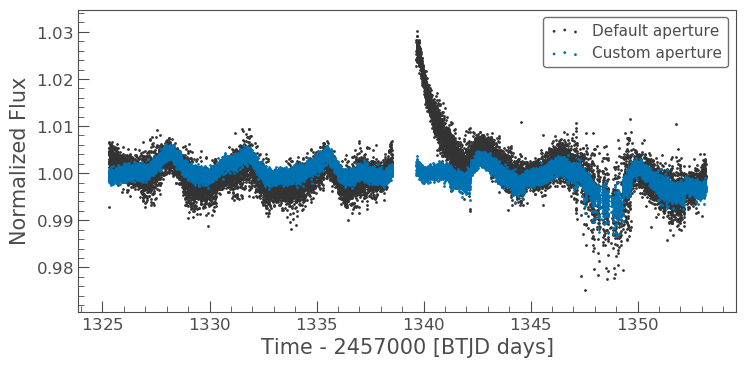

In [24]:
ax = lcf.scatter(label='Default aperture')
custom_lc.scatter(ax=ax, label='Custom aperture');

Notice how the custom aperture shows a more accurate light curve for the target object. 

### Part IV: Periodograms 
When looking at a light curve (either using `.plot()` or `.scatter()`) and there appears to be some sort of structure to it, a periodogram can be used to find the reotation period. The basic line of code to convert a light curve to a periodogram is the following:
> `pg = lc.to_periodogram(oversample_factor= )` 

Then plot the periodogram with `pg.plot();`.

To find the exact period of oscillation, garph the periodogram in "period space":
> `pg.plot(view='period', scale='log');`

To get a better fit, you can increase `oversample_factor` parameter, but keep in mind this also increases processing time. 

To find the best period use:
> `period = pg.period_at_max_power`

> `print('Best period {}'.format(period))`

This period is the ideal folding point and the light curve should look correct (unless it's an eclipsing binary, then try multiplying the `period` by the reciprocal of the previous best period, then repeat the plotting process). 

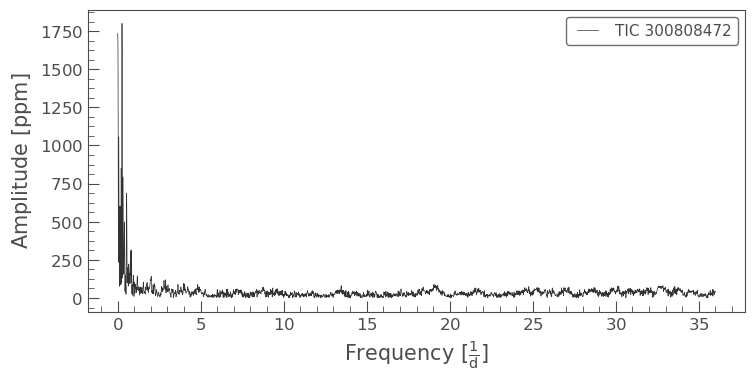

In [16]:
pg = custom_lc.to_periodogram(oversample_factor=10)
pg.plot();

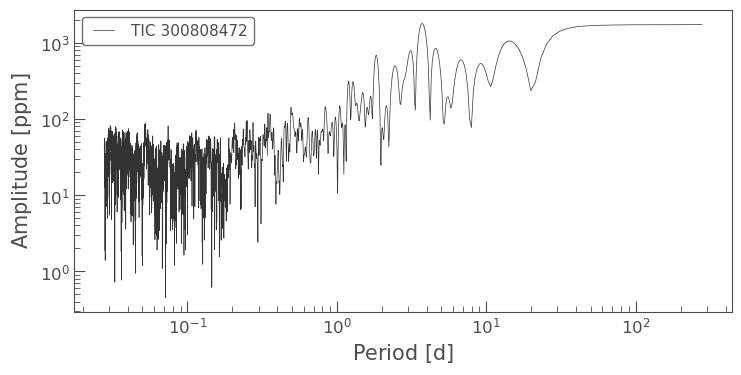

In [22]:
pg.plot(view='period', scale='log');

Best period: 3.7156842450523375 d


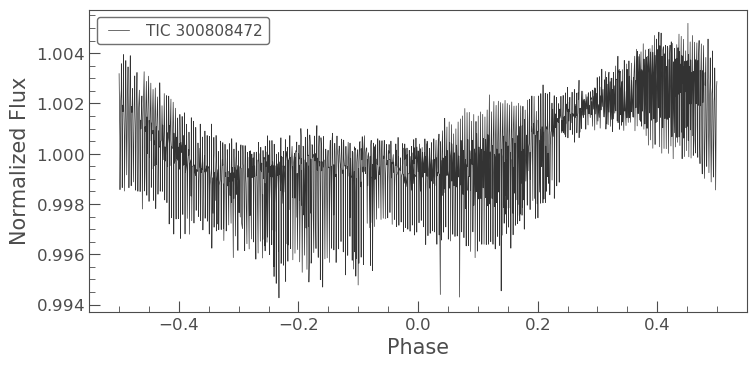

In [17]:
period = pg.period_at_max_power 
print('Best period: {}'.format(period))
custom_lc.remove_outliers(sigma=3).fold(period.value).plot();